In [1]:
import pandas as pd
import numpy as np
import sys
import os
import cv2
import matplotlib.pyplot as plt
import random
from collections import Counter

from sklearn.model_selection import train_test_split
from src.dataLoading import loadChineseMNIST, loadNormalMNIST, dataLoader
from src.featureExtraction import runPCA

### Load data

In [2]:
# Load data
mnistVectors, mnistImages, mnistLabels = loadNormalMNIST(1000)
chineseVectors, chineseImages, chineseLabels = loadChineseMNIST()

# all data combined
vectors, images, labels = dataLoader()

# PARAMETER TUNING
## PCA

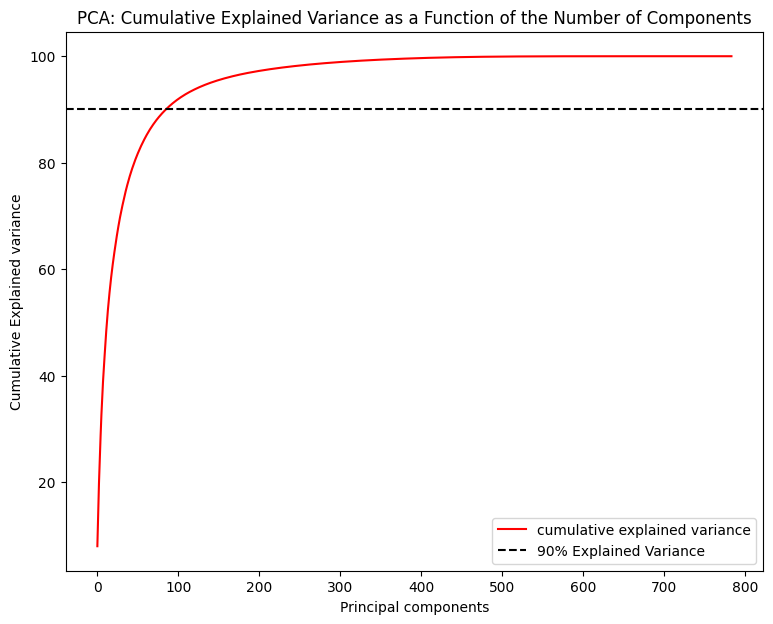

90 % of variance explained at n= 85


In [3]:
from sklearn.decomposition import PCA

#pcaXtrain, pcaXtest = runPCA(X_train, X_test)    # n_components = 85
#X_train, X_test, y_train, y_test = train_test_split(vectors, labels, train_size=0.8, stratify=labels)


# fit a PCA model to all of the data
pca = PCA()
pca.fit(vectors)

# find the culumative explained variances and plot that
cumsum = np.cumsum(pca.explained_variance_ratio_)*100
d = [n for n in range(len(cumsum))]
plt.figure(figsize=(9, 7))
plt.plot(d,cumsum, color = 'red',label='cumulative explained variance')
plt.title('PCA: Cumulative Explained Variance as a Function of the Number of Components')
plt.ylabel('Cumulative Explained variance')
plt.xlabel('Principal components')
plt.axhline(y = 90, color='k', linestyle='--', label = '90% Explained Variance')
plt.legend(loc='best')
plt.show()

# find the number of components that explain at least 90% of the data's variance
varGoal = 90
index_first_match = next(
    (index for index, item in enumerate(cumsum) if item > varGoal),
    None)
print(varGoal, "% of variance explained at n=", index_first_match) 


for SVM later:
accuracy of an SVM on PCA n=85 is 0.9785

Code for confusion matrices:

In [4]:
"""
from sklearn.metrics import confusion_matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

confusion_matrix(y_test, predictions)

cm = confusion_matrix(y_test, predictions, labels=svm.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                               display_labels=svm.classes_)
disp.plot(xticks_rotation=-90)
plt.plot()

accuracies = cm.diagonal()/cm.sum(axis=1)  # accuracies per class (as a list)

print("accuracies per class")
for lab, acc in zip(svm.classes_, accuracies):
    print(lab,":", acc)
"""

'\nfrom sklearn.metrics import confusion_matrix\nfrom sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay\n\nconfusion_matrix(y_test, predictions)\n\ncm = confusion_matrix(y_test, predictions, labels=svm.classes_)\ndisp = ConfusionMatrixDisplay(confusion_matrix=cm,\n                               display_labels=svm.classes_)\ndisp.plot(xticks_rotation=-90)\nplt.plot()\n\naccuracies = cm.diagonal()/cm.sum(axis=1)  # accuracies per class (as a list)\n\nprint("accuracies per class")\nfor lab, acc in zip(svm.classes_, accuracies):\n    print(lab,":", acc)\n'

## Tuning K-Means

In [5]:
from sklearn.cluster import KMeans
import numpy as np
import pandas as pd


# quick and easy Kmeans function to fit a model and return the inertia
def K_means(x_train, x_test, n_components):  
    kmeans = KMeans(n_clusters=n_components)
    kmeans.fit(x_train)
    return kmeans.inertia_


# find MSE of K_means models with different K values (on each dataset as well as the combined one)
MSEs = pd.DataFrame(columns=['dataset', 'k','inertia'])
n_components = np.arange(10, 31, 1)

names = ['mnist','chinese']
vectorData = [mnistVectors/255, chineseVectors/255, vectors/255]
Labels = [mnistLabels, chineseLabels, labels]
row = 0

for ii in range(len(names)):
    name = names[ii]
    data=vectorData[ii]
    labels = Labels[ii]
    X_train, X_test, y_train, y_test = train_test_split(data, labels, train_size=0.8, random_state=42)
    
    for comps in n_components:
        row+=1
        inertia = K_means(X_train, X_test, comps)
        MSEs.loc[row] = [name, comps, inertia]

C:\Users\danie\AppData\Local\Temp\ipykernel_18932\3687925068.py:2: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for label, df in MSEs.groupby(['dataset']):


IndexError: list index out of range

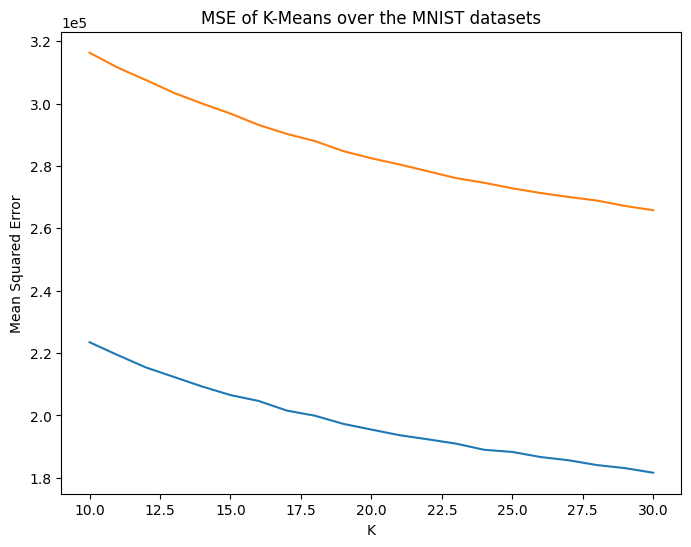

In [6]:
fig, ax = plt.subplots(figsize=(8,6))
for label, df in MSEs.groupby(['dataset']):
    plt.plot(df['k'], df['inertia'], label=label)

plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
plt.title('MSE of K-Means over the MNIST datasets')
plt.xlabel('K')
plt.ylabel('Mean Squared Error')

# some magic to make nicer and well-arranged labels
newLabels = ['chinese MNIST', 'both','classic MNIST']
handles, labels = plt.gca().get_legend_handles_labels()
order = [0,2,1]
plt.legend([handles[idx] for idx in order],[newLabels[idx] for idx in order])

![green-divider](https://user-images.githubusercontent.com/7065401/52071924-c003ad80-2562-11e9-8297-1c6595f8a7ff.png)

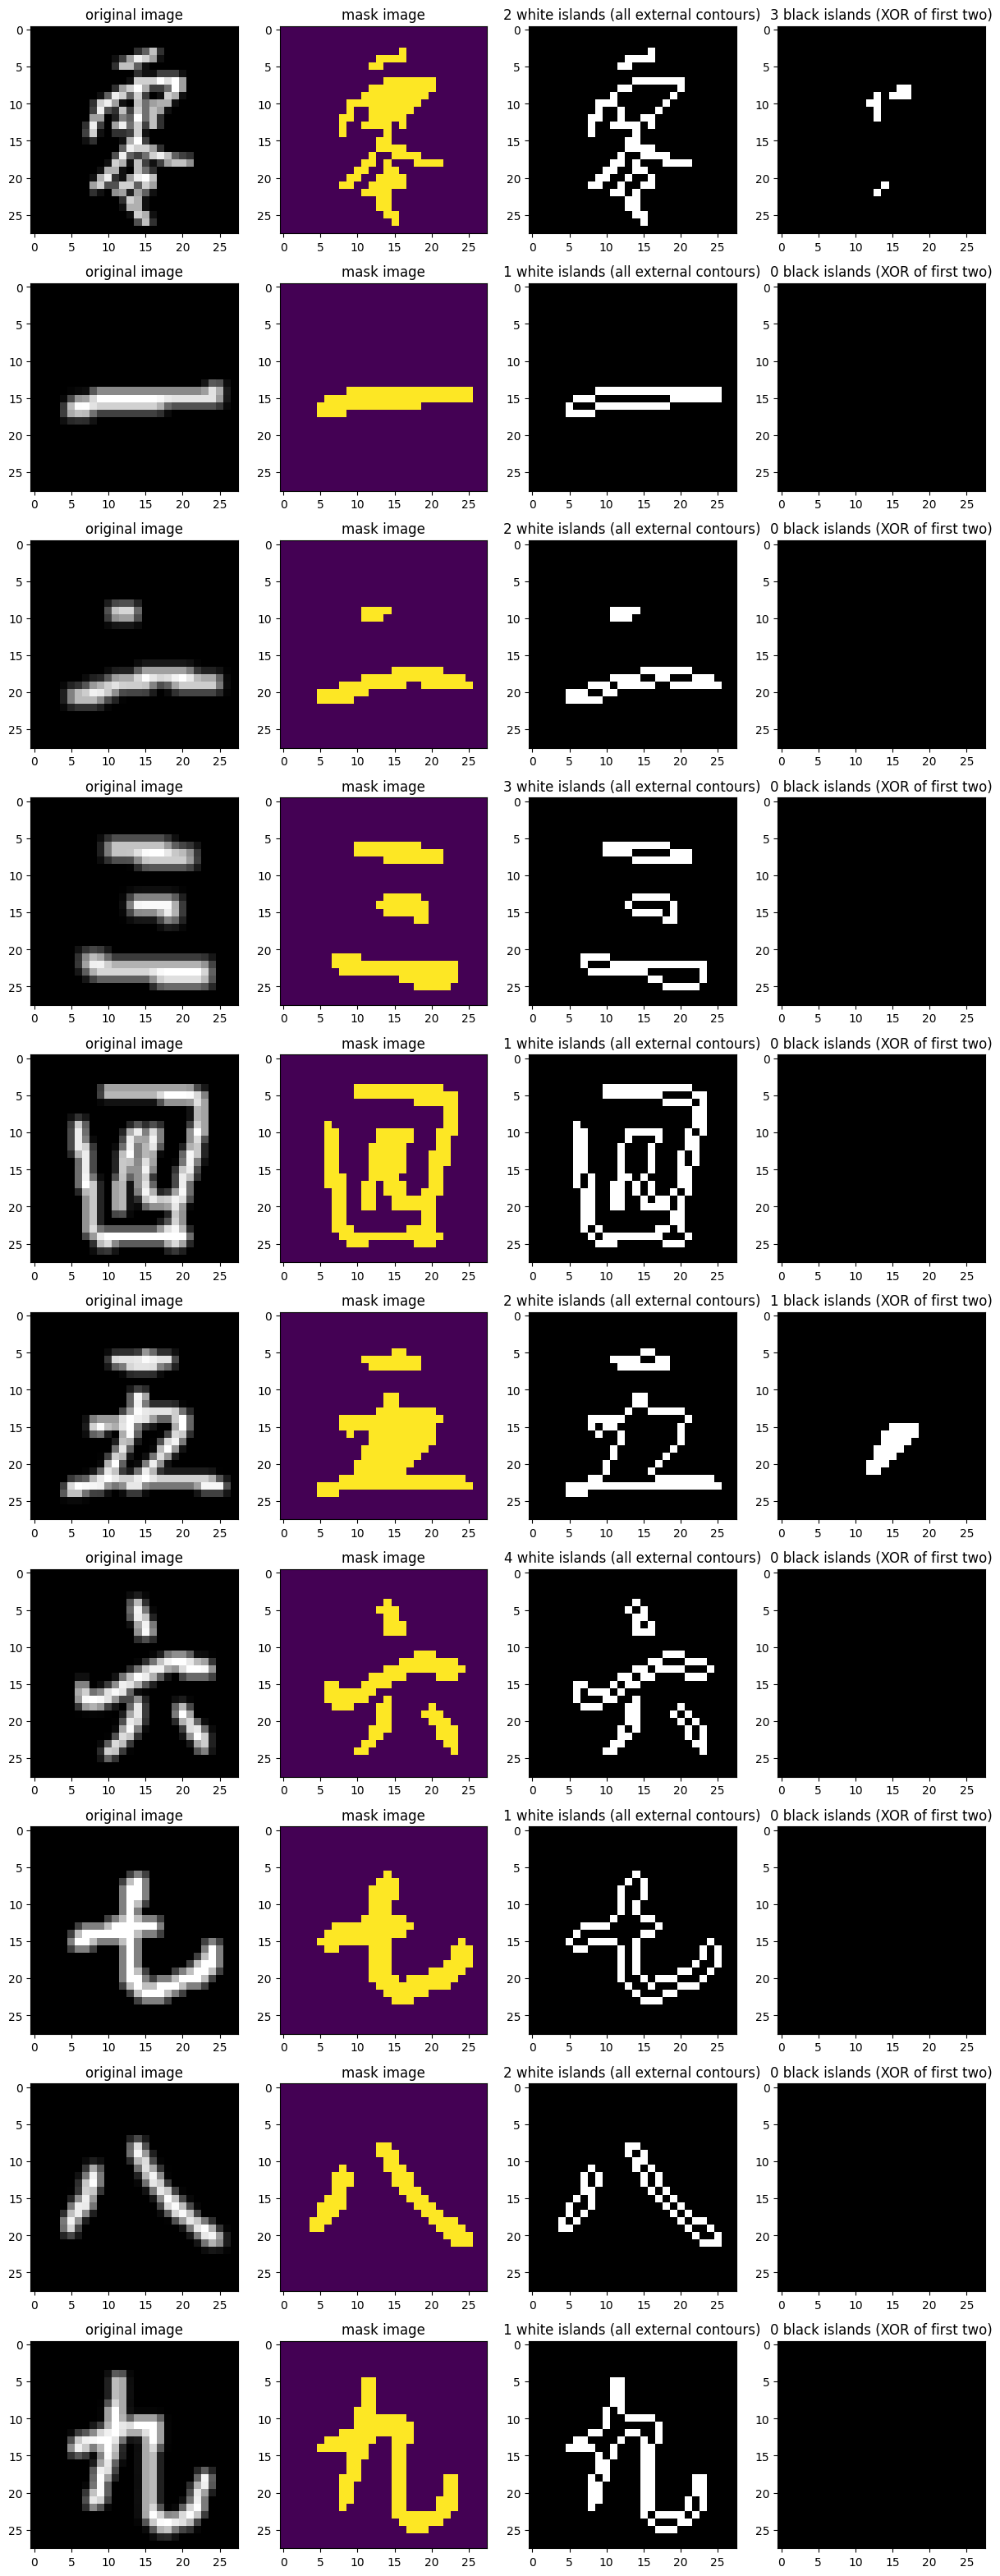

In [6]:
#plotting stuff
fig, ax = plt.subplots(10,4, figsize=(15,4*10))
font=cv2.FONT_HERSHEY_SIMPLEX
fontScale=0.1
fontColor=(255,255,255)
org=(2,5)

for Class in range(10):
    # Load image, make blank mask, define rough contour points
    img = chineseImages[Class*1000 + random.randint(0,1000)]
    image = img.astype('uint8')

    ret, thresholdedIm = cv2.threshold(image, 100, 255, cv2.THRESH_BINARY)
    contours, _  = cv2.findContours(thresholdedIm, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

    # get the white islands (just use the countours, this works fine)
    whiteIslands = np.zeros_like(thresholdedIm)
    numWhiteIslands = str(len(contours))
    cv2.drawContours(whiteIslands, contours, -1, (255,255,0), 0)

    # Draw contour onto blank mask
    mask = np.zeros_like(thresholdedIm)
    cv2.fillPoly(mask, pts=contours, color=(255, 255, 255))
    # use XOR between the mask and the thresholded image to find the black islands
    blackIslands = cv2.bitwise_xor(thresholdedIm, mask)
    blackContours, _ = cv2.findContours(blackIslands, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    numBlackCountours = str(len(blackContours))

    
    ax[Class,0].imshow(image, cmap='gray')
    ax[Class,0].set_title('original image')
    ax[Class,1].imshow(mask)
    ax[Class,1].set_title('mask image')
    ax[Class,2].imshow(whiteIslands, cmap='gray')
    ax[Class,2].set_title(numWhiteIslands + ' white islands (all external contours)')
    ax[Class,3].imshow(blackIslands, cmap='gray')
    ax[Class,3].set_title(numBlackCountours + ' black islands (XOR of first two)')

plt.show()


In [13]:
import numpy as np
import cv2


def islandCounter(data):
    length = len(data)
    whiteIslandsArray = np.zeros(length)
    blackIslandsArray = np.zeros(length)
    for ii in range(length):
        image = data[ii].astype('uint8')

        # get the external edges (white object on black background)
        ret, thresholdedIm = cv2.threshold(image, 100, 255, cv2.THRESH_BINARY)
        contours, _  = cv2.findContours(thresholdedIm, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

        # get the number of white islands (just use the contours, this works fine)
        whiteIslands = np.zeros_like(thresholdedIm)
        numWhiteIslands = len(contours)
        whiteIslandsArray[ii] = numWhiteIslands

        # Draw contour onto blank mask
        mask = np.zeros_like(thresholdedIm)
        cv2.fillPoly(mask, pts=contours, color=(255, 255, 255))
        # use XOR between the mask and the thresholded image to find the black islands
        blackIslands = cv2.bitwise_xor(thresholdedIm, mask)

        # get the number of black islands
        blackContours, _ = cv2.findContours(blackIslands, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
        numBlackIslands = len(blackContours)
        blackIslandsArray[ii] = numBlackIslands

    return whiteIslandsArray, blackIslandsArray

whites, blacks = islandCounter(chineseImages)

# Mixtures of Gaussians Model Tuning

In [31]:
def makeNewLabels(oldLabels, chinese=False):
    newLabels = []
    for lab in oldLabels:
        if chinese == True:
            newLab = "chinese_"+str(lab)
        else:
            newLab = "mnist_"+str(lab)
        newLabels.append(newLab)
    return newLabels


newCLabels = makeNewLabels(chineseLabels, chinese=True)
newChineseLabels = makeNewLabels(chineseLabels, chinese=True)

['mnist_0',
 'mnist_0',
 'mnist_0',
 'mnist_0',
 'mnist_0',
 'mnist_0',
 'mnist_0',
 'mnist_0',
 'mnist_0',
 'mnist_0',
 'mnist_0',
 'mnist_0',
 'mnist_0',
 'mnist_0',
 'mnist_0',
 'mnist_0',
 'mnist_0',
 'mnist_0',
 'mnist_0',
 'mnist_0',
 'mnist_0',
 'mnist_0',
 'mnist_0',
 'mnist_0',
 'mnist_0',
 'mnist_0',
 'mnist_0',
 'mnist_0',
 'mnist_0',
 'mnist_0',
 'mnist_0',
 'mnist_0',
 'mnist_0',
 'mnist_0',
 'mnist_0',
 'mnist_0',
 'mnist_0',
 'mnist_0',
 'mnist_0',
 'mnist_0',
 'mnist_0',
 'mnist_0',
 'mnist_0',
 'mnist_0',
 'mnist_0',
 'mnist_0',
 'mnist_0',
 'mnist_0',
 'mnist_0',
 'mnist_0',
 'mnist_0',
 'mnist_0',
 'mnist_0',
 'mnist_0',
 'mnist_0',
 'mnist_0',
 'mnist_0',
 'mnist_0',
 'mnist_0',
 'mnist_0',
 'mnist_0',
 'mnist_0',
 'mnist_0',
 'mnist_0',
 'mnist_0',
 'mnist_0',
 'mnist_0',
 'mnist_0',
 'mnist_0',
 'mnist_0',
 'mnist_0',
 'mnist_0',
 'mnist_0',
 'mnist_0',
 'mnist_0',
 'mnist_0',
 'mnist_0',
 'mnist_0',
 'mnist_0',
 'mnist_0',
 'mnist_0',
 'mnist_0',
 'mnist_0',
 'mn

In [35]:
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score


newChineseLabels = makeNewLabels(chineseLabels, chinese=True)
newMnistLabels = makeNewLabels(mnistLabels, chinese=False)

data = np.concatenate([chineseVectors, mnistVectors])
labels = np.concatenate([newChineseLabels, newMnistLabels])

#mnistVectors, mnistImages, mnistLabels = loadNormalMNIST(1000)
#chineseVectors, chineseImages, chineseLabels

#X_train, X_test, y_train, y_test = train_test_split(data, labels, train_size=0.8, random_state=42)

In [4]:
results = pd.DataFrame(columns=['n','covar_type','AIC','BIC'])

covars = ['full']#, 'tied', 'diag', 'spherical']
n_components = np.arange(1, 41, 1)

#data = X_train
row = 0
for cov in covars:
    for n in n_components:
        row += 1
        print(cov, n)
        gm = GaussianMixture(n, covariance_type='full', 
                        random_state=0, tol=0.01).fit(data)
        results.loc[row] = [n, cov, gm.bic(data), gm.aic(data)]
        

full 1
full 2
full 3
full 4
full 5
full 6
full 7
full 8
full 9
full 10
full 11
full 12
full 13
full 14
full 15
full 16
full 17
full 18
full 19
full 20
full 21
full 22
full 23
full 24
full 25
full 26
full 27
full 28
full 29
full 30
full 31
full 32
full 33
full 34
full 35
full 36
full 37
full 38
full 39
full 40


Text(0, 0.5, 'AIC / BIC')

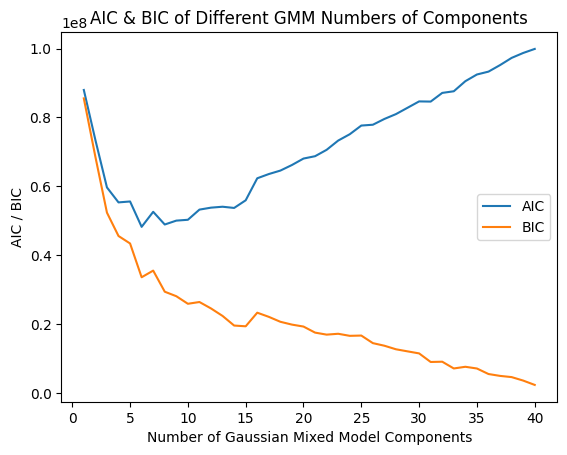

In [28]:
N = results['n']
AIC = results['AIC']
BIC = results['BIC']


plt.plot(N, AIC, label='AIC')
plt.plot(N, BIC, label='BIC')
plt.legend(loc='center right')
plt.title("AIC & BIC of Different GMM Numbers of Components")
plt.xlabel("Number of Gaussian Mixed Model Components")
plt.ylabel("AIC / BIC")

![green-divider](https://user-images.githubusercontent.com/7065401/52071924-c003ad80-2562-11e9-8297-1c6595f8a7ff.png)

FFT

In [8]:
import heapq
import cv2
import matplotlib.pyplot as plt
import numpy as np
from numpy.fft import fft2, fftshift, ifft2, ifftshift

def fftCompress(image, size, plot=False):
    # does a 2D fft on the image, and compresses it to a vector of length 'size'
    ftImage = fft2(image)
    fI_thresh = ftImage.copy()  
    
    ftImageStretched = ftImage.ravel()
    threshold = np.sort( abs(ftImageStretched) ) [-size] 

    # use Heap queue algorithm to find the highest 'size' value
    # (the old method of looping through the list and using the threshold
    # sometimes returned 1 too many values, but this always works)
    shortenedFTImage = heapq.nlargest(size, abs(ftImageStretched))  

    if plot:
        plt.imshow(image, cmap=plt.get_cmap("gray"))
        plt.title('Original image')
        plt.show
        fI_thresh[ abs(ftImage) < threshold ] = 0
        I_thresh = np.real(ifft2(fI_thresh))
        display_2( I_thresh, "Compressed Image", fftshift( np.log(1e-7 + abs(ftImage)) ), "Fourier Transform" )

    return shortenedFTImage 


def fourierTransformAllImages(allImages, size):
    size = size
    output = []
    for image in allImages:
        image = np.reshape(image, (28,28))
        compressedImage = fftCompress(image, size, plot=False)
        output.append(compressedImage)
    return output  


def display_2(im_1, title_1, im_2, title_2):
    """  Displays two images side by side; typically, an image and its Fourier transform. """
    plt.figure(figsize=(12,6))                    
    plt.subplot(1,2,1) ; plt.title(title_1)       
    plt.imshow(im_1, cmap="gray")                 
    plt.subplot(1,2,2) ; plt.title(title_2)  
    plt.imshow(im_2, cmap="gray", vmin=-7, vmax=15)
    plt.show() 

In [5]:
print(len(X_train[0]))

784


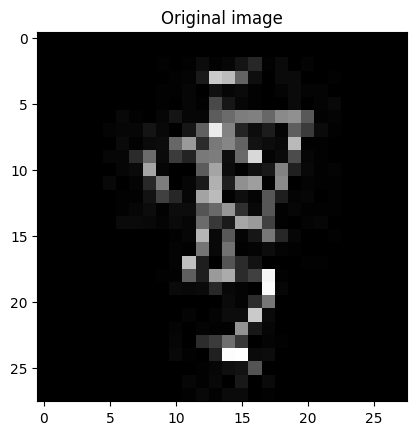

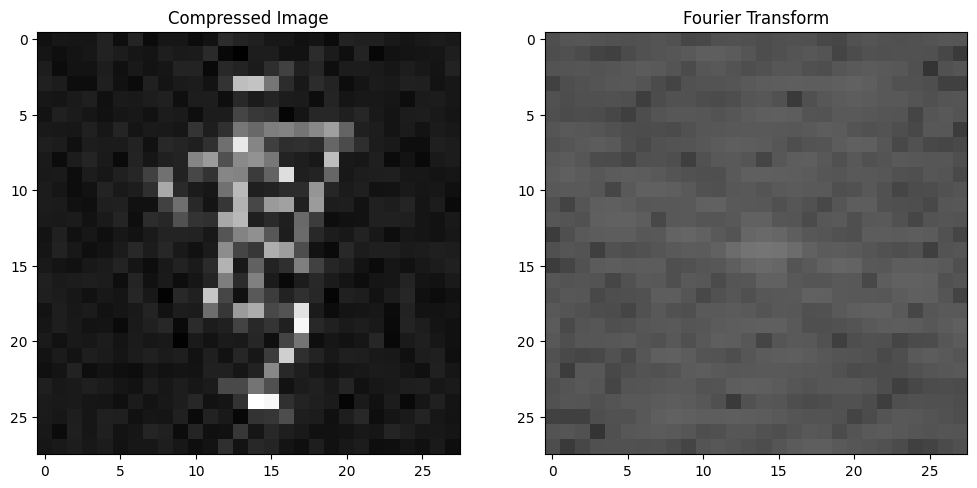

500


In [6]:
example = X_train[1]
example = np.reshape(example, (28,28))
feature_vec = fftCompress(example, 500, plot=True)
print(len(feature_vec))

In [12]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score


fftData = fourierTransformAllImages(data, 100)


X_train, X_test, y_train, y_test = train_test_split(fftData, labels, train_size=0.8, random_state=42)

svm = SVC().fit(X_train, y_train)

predictions = svm.predict(X_test)
accuracy = accuracy_score(y_test, predictions)
print("acc:", accuracy)

acc: 0.687
